---
title: "Group Assignment 2"
subtitle: "Group 11"
date: "2025-10-01"
date-format: "MMMM YYYY"
format: pdf
---
\newpage
\tableofcontents
\listoffigures
\listoftables
\newpage

In [550]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(scales)

In [551]:
sp_data <- read.csv("sp500_2023_2024.csv")

# Remove the rows whose prcod values are NA
sp_data <- filter(sp_data, !is.na(prcod))

# Change datadate format type
sp_data$datadate <- as.Date(sp_data$datadate, format = "%d/%m/%Y")

# Part I

## Q1

In [552]:
# Calculate the unique number of tickers
n_distinct(sp_data$tic)

[1] 502

## Q2

In [553]:
# Calculate the unique number of companies
n_distinct(sp_data$conm)

[1] 499

## Q3

In [554]:
#| tbl-cap: "Top 5 comapanies by largest mean trading volume"

# Display the top  5 companies by largest mean trading volume
sp_data %>%
  group_by(conm) %>%
  summarise(mean_trading_volume = mean(cshtrd)) %>%
  arrange(desc(mean_trading_volume)) %>%
  head(n = 5)

conm,mean_trading_volume
<chr>,<dbl>
TESLA INC,115314383
NVIDIA CORP,113131835
PALANTIR TECHNOLOG INC,60056251
APPLE INC,57736403
ADVANCED MICRO DEVICES,57143415


## Q4

In [555]:
#| tbl-cap: "Top 3 exchanges by largest total trading volume"

# Display the total trading volume of the top 3 exchanges
# by largest total trading volume
top_exchanges <- sp_data %>%
  group_by(exchg) %>%
  summarise(total_trading_volume = sum(cshtrd)) %>%
  arrange(desc(total_trading_volume)) %>%
  head(n = 3)

top_exchanges

exchg,total_trading_volume
<int>,<dbl>
11,681415756062
14,570830885382
21,385399362


## Q5

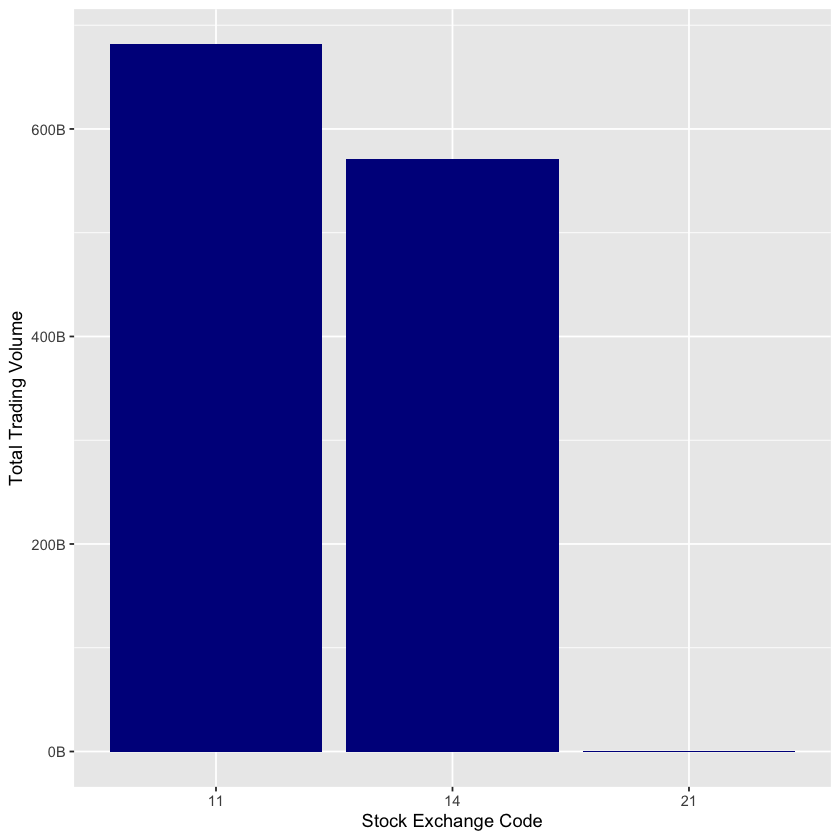

In [556]:
#| fig-cap: "Top 3 exchanges by largest total trading volume"

# Visualise the total trading volume of the top 3 exchanges
# by largest total trading volume
ggplot(top_exchanges, aes(factor(exchg), total_trading_volume)) +
  geom_col(fill = "dark blue") +
  scale_y_continuous(labels = label_number(scale = 1e-9, suffix = "B")) +
  labs(x = "Stock Exchange Code", y = "Total Trading Volume")

## Q6

In [557]:
# Calculate the number of companies with more than 1 ticker
multiple_ticker_num <- sp_data[, c("tic", "conm")] %>%
  group_by(conm) %>%
  summarise(tic_num = n_distinct(tic)) %>%
  filter(tic_num > 1)

nrow(multiple_ticker_num)

[1] 3

## Q7

In [558]:
# Find ticker that has the largest positive mean return (simple daily return)
sp_data %>%
  group_by(tic) %>%
  mutate(daily_return = (prccd - lag(prccd)) / lag(prccd)) %>%
  summarise(mean_daily_return = mean(daily_return, na.rm = TRUE)) %>%
  arrange(desc(mean_daily_return)) %>%
  head(n = 1)

tic,mean_daily_return
<chr>,<dbl>
PLTR,0.005785119


## Q8

In [559]:
# Find company that has the largest positive mean return (simple daily return)
sp_data %>%
  group_by(conm) %>%
  mutate(daily_return = (prccd - lag(prccd)) / lag(prccd)) %>%
  summarise(mean_daily_return = mean(daily_return, na.rm = TRUE)) %>%
  arrange(desc(mean_daily_return)) %>%
  head(n = 1)

conm,mean_daily_return
<chr>,<dbl>
PALANTIR TECHNOLOG INC,0.005785119


## Q9

In [560]:
# Find industry that includes the largest number of companies
sp_data %>%
  group_by(sic) %>%
  summarise(company_num = n_distinct(conm)) %>%
  arrange(desc(company_num)) %>%
  head(n = 1)

sic,company_num
<int>,<int>
6798,28


# Part II

## Q1

In [561]:
# Calculate simple weekly returns for each ticker in the full dataset
# using the following formula
weekly_sp_data <- sp_data %>%
  mutate(week = floor_date(datadate, "week")) %>%
  group_by(tic, week) %>%
  arrange(datadate) %>%
  summarise(week_end_close_price = last(prccd)) %>%
  ungroup()

head(weekly_sp_data)

`summarise()` has grouped output by 'tic'. You can override using the `.groups`
argument.


tic,week,week_end_close_price
<chr>,<date>,<dbl>
A,2023-01-01,147.67
A,2023-01-08,156.92
A,2023-01-15,155.92
A,2023-01-22,155.69
A,2023-01-29,154.55
A,2023-02-05,152.55


In [562]:
weekly_sp_data <- weekly_sp_data %>%
  group_by(tic) %>%
  arrange(tic, week) %>%
  mutate(weekly_return = ((week_end_close_price - lag(week_end_close_price)) /
                            lag(week_end_close_price))) %>%
  na.omit() %>%
  ungroup()

head(weekly_sp_data)

tic,week,week_end_close_price,weekly_return
<chr>,<date>,<dbl>,<dbl>
A,2023-01-08,156.92,0.062639670
A,2023-01-15,155.92,-0.006372674
A,2023-01-22,155.69,-0.001475115
A,2023-01-29,154.55,-0.007322243
A,2023-02-05,152.55,-0.012940796
A,2023-02-12,148.26,-0.028121927


## Q2

In [563]:
# Categorise data into decile groups based on simple weekly returns,
# labelled 0%, 10%, 20%, ...

weekly_sp_data <- weekly_sp_data %>%
  mutate(deciles = cut(weekly_return,
                        breaks = quantile(weekly_return,
                        probs = seq(0, 1, by = 0.1),
                        type = 5, na.rm = TRUE), include.lowest = TRUE,
                        labels = paste0(0:9 * 10, "%")))
                        
head(weekly_sp_data)

tic,week,week_end_close_price,weekly_return,deciles
<chr>,<date>,<dbl>,<dbl>,<fct>
A,2023-01-08,156.92,0.062639670,90%
A,2023-01-15,155.92,-0.006372674,30%
A,2023-01-22,155.69,-0.001475115,40%
A,2023-01-29,154.55,-0.007322243,30%
A,2023-02-05,152.55,-0.012940796,30%
A,2023-02-12,148.26,-0.028121927,10%


## Q3

In [564]:
# Display a table showing the top ticker (ticker with the highest weekly return)
# in each decile group
top_tickers <- weekly_sp_data %>%
  group_by(deciles) %>%
  slice(which.max(weekly_return)) %>%
  select(deciles, tic, weekly_return) %>%
  arrange(deciles)

print(top_tickers)

# A tibble: 10 x 3
# Groups:   deciles [10]
   deciles tic   weekly_return
   <fct>   <chr>         <dbl>
 1 0%      DVN        -0.0415 
 2 10%     FDS        -0.0248 
 3 20%     TRMB       -0.0141 
 4 30%     NWS        -0.00544
 5 40%     CDNS        0.00228
 6 50%     AIG         0.0101 
 7 60%     HLT         0.0185 
 8 70%     RL          0.0292 
 9 80%     SJM         0.0470 
10 90%     SMCI        0.784  


## Q4

In [565]:
# Select the top ticker from the 60% decile group
top_tickers %>%
  filter(deciles == "60%") %>%
  print()

# A tibble: 1 x 3
# Groups:   deciles [1]
  deciles tic   weekly_return
  <fct>   <chr>         <dbl>
1 60%     HLT          0.0185


## Q5

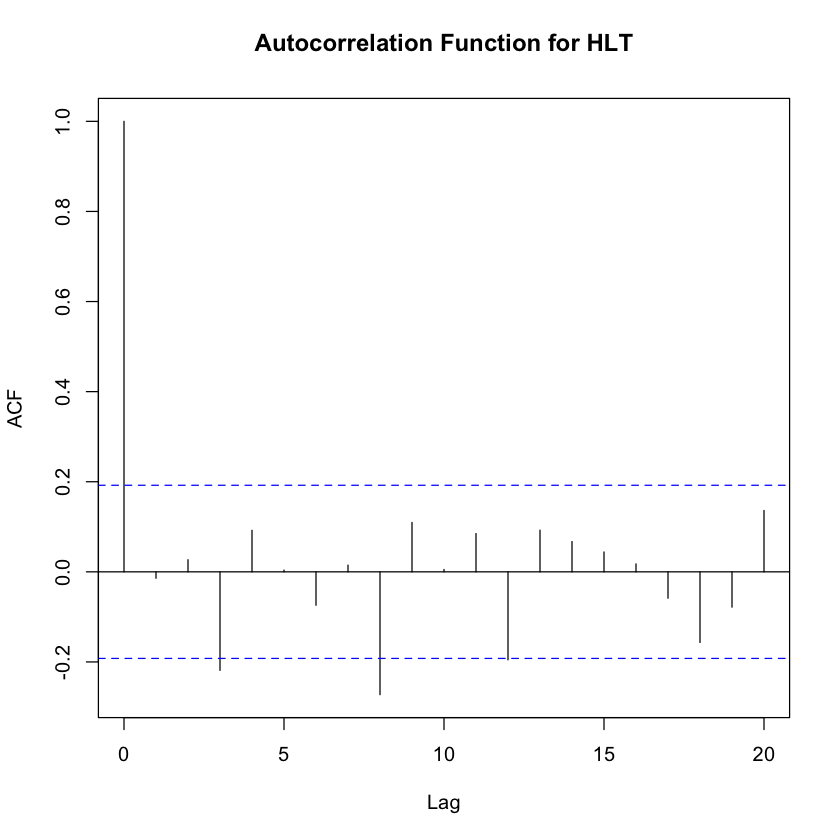

In [566]:
#| fig-cap: "Autocorrelation Function for HLT"

# Plot the autocorrelation function for this ticker's
# entire set of weekly returns
hlt_data <- filter(weekly_sp_data, tic == "HLT")

acf(hlt_data$weekly_return, main = "Autocorrelation Function for HLT")

# Part III

## Q1

In [567]:
# Load and clean the weekly Fama-French 3 factor data
ff3 <- read.csv("fama_french_weekly.csv", skip = 4)

# Remove blank data
ff3 <- na.omit(ff3)

# Change coloumns name
colnames(ff3) <- c("datadate", "Mkt_RF", "SMB", "HML", "RF")

# Convert to decimal
ff3[-1] <- ff3[-1] / 100

# Change date format
ff3$datadate <- as.Date(ff3$datadate, format = "%Y%m%d")

# Add a column named "week" for further analysis
ff3 <- mutate(ff3, week = floor_date(datadate, "week"))

# Remain weekly data with ideal dates
ff3_cleaned <- ff3 %>%
  select("week", "Mkt_RF", "SMB", "HML", "RF")

head(ff3_cleaned)

,week,Mkt_RF,SMB,HML,RF
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,1926-06-27,0.0158,-0.0062,-0.0086,6e-04
2,1926-07-04,0.0037,-0.0090,0.0031,6e-04
3,1926-07-11,0.0098,0.0059,-0.0144,6e-04
4,1926-07-18,-0.0203,0.0002,-0.0017,6e-04
5,1926-07-25,0.0306,-0.0189,-0.0085,6e-04
6,1926-08-01,0.0204,0.0016,0.0055,6e-04


## Q2

In [568]:
# Fit the Fama-French 3 factor model to the weekly returns
# of the stock selected in Part II

ff3_model <- merge(hlt_data, ff3_cleaned, by = "week")

ff3_model <- ff3_model %>%
  mutate(excess_return = weekly_return - RF) %>%
  select("week", "excess_return", "Mkt_RF", "SMB", "HML", "RF")

head(ff3_model)

summary(lm(excess_return ~ Mkt_RF + SMB + HML, data = ff3_model))

,week,excess_return,Mkt_RF,SMB,HML,RF
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2023-01-08,0.050002111,0.0302,0.0337,-0.0324,9e-04
2,2023-01-15,0.012542431,-0.0069,0.0012,-0.0115,9e-04
3,2023-01-22,0.042280507,0.0257,-0.0009,-0.0122,9e-04
4,2023-01-29,0.013680886,0.0181,0.0354,-0.0199,9e-04
5,2023-02-05,0.001483871,-0.0149,-0.0320,0.0266,9e-04
6,2023-02-12,-0.006539736,0.0010,0.0203,-0.0147,9e-04



Call:
lm(formula = excess_return ~ Mkt_RF + SMB + HML, data = ff3_model)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.050719 -0.010592 -0.000428  0.011555  0.035722 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.002611   0.001868   1.398  0.16527    
Mkt_RF       0.965943   0.109272   8.840 3.44e-14 ***
SMB         -0.058955   0.121771  -0.484  0.62934    
HML          0.327167   0.109504   2.988  0.00354 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0185 on 100 degrees of freedom
Multiple R-squared:  0.4826,	Adjusted R-squared:  0.4671 
F-statistic: 31.09 on 3 and 100 DF,  p-value: 2.766e-14
